In [51]:
import matplotlib.pyplot as plt  
import pandas as pd
import matplotlib.dates as mdates
from scipy import stats
import xarray as xr

Relationship between Sea Ice and Methane Emission in the Arctic from 2002 to 2021

Hiroki Kurihara 

OCEAN 215 Final Project  
Autumn 2024

## Introduction

Sea ice traps gases like methane as it forms, locking them in the frozen layers. When the ice melts, these gases are released into the atmosphere or ocean. This process plays a key role in how sea ice affects methane levels and contributes to climate change. Therefore, this time, I investigated the relationship between amount of sea ice and amount of methane emitted in the arctic from 2002 to 2021. My hypothesis was that there is an inverse relationship between those two, which means that as amount of sea ice decreases, the emission of methane increases. 

# Data sources:
<!-- List each data source used in your project. For each dataset, include: 
     - Where you accessed it from 
     - Date you accessed/downloaded it 
     - Data collection process
     - Relevant variables (including unit) 
     - Spatial and temporal coverage and resolution 
     - Description of any obstacles or challenges you faced in obtaining the dataset
     - URL to the dataset if available -->

- Sea Ice Index
  - Downloaded from Arctic Data Center on 11-25-2024
  - Data collection process: Data collected by satelites
  - Relevant variables included: Sea Ice Index (10^6 sq km)
  - Spatial coverage and resolution: 
    - lat: 90-31N
    - lon: 180E-180W
  - Obstacles to data access: none
  - Temporal coverage and resolution: every two days
  - URL to dataset: https://arcticdata.io/catalog/view/doi%3A10.18739%2FA2280513H

- Methane Emission
  - Downloaded from NASA Earth Data on 11-25-2024
  - Data collection process: Data collected by Eddy covariance towers and chambers on the Arctic
  - Relevant variables included: Methane Weekly Mean (teragrams/day)
  - Spatial coverage and resolution: 
    - lat: 90-45N
    - lon: 180E-180W
  - Obstacles to data access: I had to create an account to access data, and I kept getting error at first point, but I could access it after contacing the data center
  - Temporal coverage and resolution: every week
  - URL to dataset: https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2351

## 1. Sea Ice Index

<!-- In this cell, introduction the data set(s) you are working with, specify which aspect of your research question this section addresses, and describe the figure you will produce. -->

To find a trend of the amount of sea ice, I used a data called sea ice index. Sea ice index is a data product that shows the area of ocean covered by ice. For this, I am using a sea ice index of Arctic collected by Arctic Data Center, which covers latitude of 90-31N and longtitude of 180E to 180W.

In [52]:
# load data file
filepath = 'N_seaice_extent_daily_v3.0.csv'
data = pd.read_csv(filepath, usecols=[0, 1, 2, 3], skiprows=2, names=["YYYY", "MM", "DD", "Extent"])

In [53]:
# filter the data
filtered = data[(data["YYYY"].astype(int) >= 2002) & (data["YYYY"].astype(int) <= 2021)]

filtered = filtered.copy()
# add datetime value on the dataset
filtered['datetime'] = pd.to_datetime(filtered[['YYYY', 'MM', 'DD']].astype(str).agg('-'.join, axis=1))
# make it an index
filtered.set_index('datetime', inplace=True)
# find mean of each year
ice_annual = filtered.resample("YS").mean()

In [54]:
# find line of best fit
ice_annual['time_1'] = ice_annual.index.year
ice_slope, ice_intercept, ice_r, ice_p, ice_stdarr = stats.linregress(ice_annual['time_1'], 
                                                                       ice_annual['Extent'])
# equation of line of best fit
ice_fit = ice_annual['time_1'] * ice_slope + ice_intercept

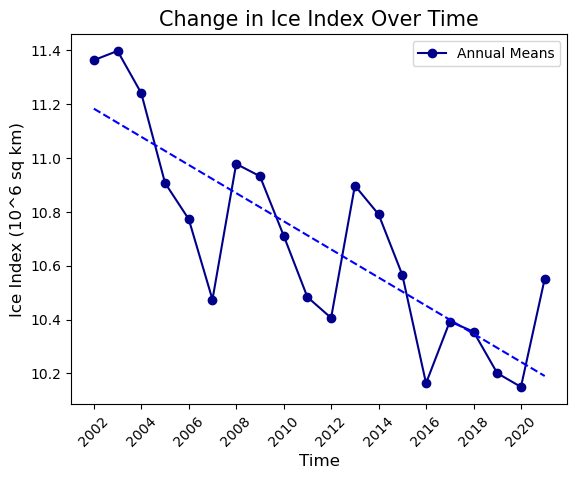

In [55]:
# create a plot
fig, axs = plt.subplots()
x = ice_annual.index
y = ice_annual['Extent']

# plot x and y valaues
axs.plot(x, y, marker = 'o', c = 'darkblue', label = 'Annual Means')
# add x-axis label
axs.set_xlabel("Time", fontsize = 12)
# add y-axis label
axs.set_ylabel("Ice Index (10^6 sq km)", fontsize = 12)
# add title
axs.set_title("Change in Ice Index Over Time", fontsize = 15)

axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
# rotate years on x-axis so they don't overlap
axs.tick_params(axis='x', labelrotation=45) 

# add legend
axs.legend()

# plot best fit line
axs.plot(ice_annual.index, ice_fit, '--', c = 'blue', label = 'Methane Fit')

<!-- Describe how this figure helps address your research question. What patterns or insights can you observe? -->
**Figure 1 Caption:** This figure shows the trend of change in amount of sea ice over time in the Arctic. As shown, the sea ice is decreasing over the period of time.

## 2. Methane Emission  

<!-- In the introduction below, specify the data set(s) you are working with in this section, which aspect of your research question this section addresses, and the figure you will produce -->

I am using the data of methane emission collected by NASA Earth Data. This data set covers latitude of 90-45N and longtitude of 180E-180W. Since it has a different range with sea ice index, it might not be the perfect data set to compare the trends, but I came to a conclusion that it is accurate enough to see the overall trends since this change will not change the overall trends.

In [56]:
# load data file
filepath = "FCH4_upscale_BorealArctic_weekly_2002-2021.nc"
data = xr.open_dataset(filepath)

In [57]:
# clean the data
time = data['time'].values
CH4_emission = data['FCH4_weekly_mean'].mean(dim=["lon", "lat"]).values 

# convert to pd to make things easier afterwards
# first, I did not do this and I was using xarray data, so I kept getting errors
time_df = pd.to_datetime(time)
data = pd.DataFrame({ 
    "YYYY": time_df.year,
    "MM": time_df.month,
    "DD": time_df.day,
    "CH4": CH4_emission
})

# add time value to the data set
data['Time'] = time_df
data = data.set_index('Time')

# find the mean
mean = data['CH4'].resample("YS").mean()
mean = mean.reset_index()
# clean the column
mean.columns = ['Time', 'Mean_CH4']

In [58]:
# find line of best fit
# normal 'time' did not work so I had to make Time_1
mean['Time_1'] = pd.to_datetime(mean['Time'], errors='coerce').dt.year
methane_slope, methane_intercept, methane_r, methane_p, methane_stdarr = stats.linregress(mean['Time_1'], mean['Mean_CH4'])
# equation of line of best fit
methane_fit = mean['Time_1'] * methane_slope + methane_intercept

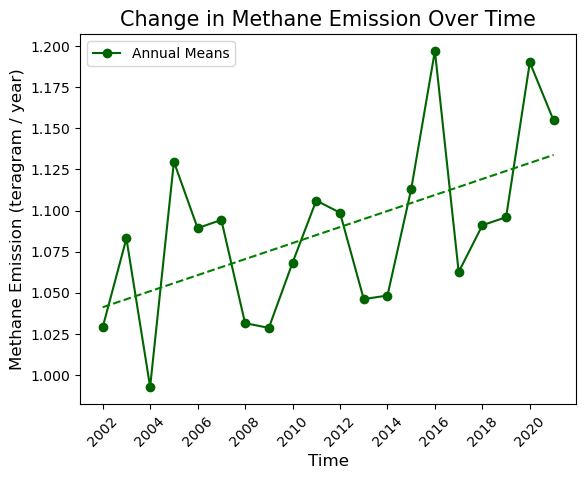

In [59]:
# create a plot
fig, axs = plt.subplots()
x = mean['Time']
y = mean['Mean_CH4']

# plot x and y values
axs.plot(x, y, marker = 'o', c = 'darkgreen', label = 'Annual Means')
# add x-axis label
axs.set_xlabel("Time", fontsize = 12)
# add y-axis label
axs.set_ylabel("Methane Emission (teragram / year)", fontsize = 12)
# add title
axs.set_title("Change in Methane Emission Over Time", fontsize = 15)

# rotate years on x-axis so they don't overlap
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
axs.tick_params(axis='x', labelrotation=45) 

# add legend
axs.legend()

# add line of best fit
axs.plot(mean['Time'], methane_fit, '--', c = 'green', label = 'Methane Fit')

<!-- Describe how this figure helps address your research question. What patterns or insights can you observe? -->
**Figure 2 Caption:** Your caption here.

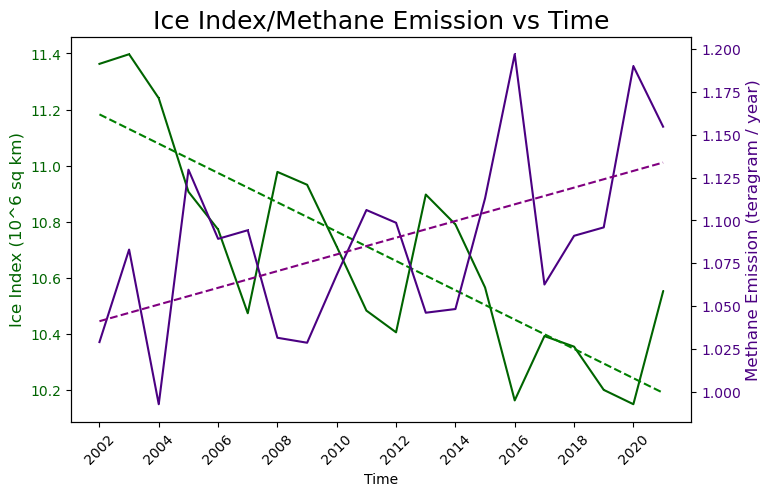

In [60]:
# create a plot
fig, ax1 = plt.subplots()
# the first dataset (sea ice index)
x1 = ice_annual.index
y1 = ice_annual['Extent']

# plot x1 and y1 values
ax1.plot(x1, y1, marker = ',', c = 'darkgreen', label = 'Annual Means')

# set the formal of date and rotate them so they don't overlap
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
ax1.tick_params(axis='x', labelrotation=45) 

# add line of best fit
ice_fit = ice_annual['time_1'] * ice_slope + ice_intercept
ax1.plot(ice_annual.index, ice_fit, '--', c = 'green', label = 'Methane Fit')

# make sure there can be no different dataset on same x-axis
ax2 = ax1.twinx()

# the second dataset (methane emission)
x2 = mean['Time']
y2 = mean['Mean_CH4']

# plot x2 and y2 values
ax2.plot(x2, y2, marker = ',', c = 'indigo', label = 'Annual Means')

# add line of best fit
methane_fit = mean['Time_1'] * methane_slope + methane_intercept
ax2.plot(mean['Time'], methane_fit, '--', c = 'purple', label = 'Methane Fit')

# label all axis and add title
ax1.set_xlabel('Time')
ax1.set_ylabel('Ice Index (10^6 sq km)', fontsize = 12, c = 'darkgreen')
ax2.set_ylabel('Methane Emission (teragram / year)', fontsize = 12, c = 'indigo')
ax1.set_title('Ice Index/Methane Emission vs Time', fontsize = 18)

# use different colors for two different dataset, so it is easier to distinguish
# it was kind of hard to find good combination of colors 
ax1.tick_params(axis = 'y', labelcolor = 'darkgreen')
ax2.tick_params(axis = 'y', labelcolor = 'indigo')

# change the size of figure
fig.set_figheight(5)
fig.set_figwidth(8)

<!-- Describe how this figure helps address your research question. What patterns or insights can you observe? -->
**Figure 3 Caption:** This figure shows both sea ice index and methane emission data on the same x-axis. By looking at this graph, it is obvious that the sea ice and methane emission are inversely proportional to each other.

## Discussion
**Interpretation of Results:** 
<!-- Summarize what you learned from each data analysis section/figure. Discuss key insights and conclusions regarding your research question. Do your results support or contradict your hypothesis? -->
Figure 1, Ice Index, shows that the amount of sea ice has been decreasing over the investigated period of time. On the other hand, Figure 2, Methane Emission, shows that the amount of methane emission has been increasing over the investigated period of time. Therefore, there is an inverse relationship between those two figures. This is much easier to see on the Figure 3. If looked on detail, the year with low ice index have high methane emission (e.g. 2012), and year with high ice index have low methane emission (e.g. 2009).

**Limitations and Future Work:**  
<!-- Identify limitations in your analysis. Discuss any factors that may have impacted the validity or reliability of your results (e.g., data quality, sample size, assumptions). -->
<!-- What next steps could you or another researcher take to continue investigating this research question? Suggest ideas for further research, data collection, or alternative methodologies that could enhance understanding of the topic. -->
This time I looked at the overall trend by year using mean of each years, which means that this investigation is ignoring all the seasonal or weather components. Therefore, the trend could be different by seasons or weather conditions which could be further investigated in the future. For example, I coould make the trend of same period of time but take data from a certain month to see the trend on each season.

## References  

1. Fetterer, Florence, et al. “Sea Ice Index: Ice Cover and Trends in Ice Cover in the Arctic and Antarctic   Oceans, Version 3, 1978-Present.” NSF Arctic Data Center the Primary Data and Software Repository for NSF Arctic Research, Arctic Data Center, arcticdata.io/catalog/view/doi%3A10.18739%2FA2280513H. Accessed 25 Nov. 2024. 

2. Yuan, K., et al. “Boreal Arctic Wetland Methane Emissions, 2002-2021.” ORNL DAAC, ORNL DAAC, 19 July 2024, daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2351. 